In [1]:
import csv
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import signal
from scipy.optimize import leastsq

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('events/normal_breathing_4.csv')
df_temp = df.where(df['type'] == 'temperature').dropna().sort_values(by=['datetime'], ascending=True)
df_pressure = df.where(df['type'] == 'pressure').dropna().sort_values(by=['datetime'], ascending=True)
df_pressure.head()

,Unnamed: 0,id,value,date,type,event_id,event_type,datetime
0,0.0,27043.0,972.50,2021-02-04T21:28:19.914Z,pressure,4.0,normal_breathing,2021-02-04 21:28:19.914
2,2.0,27042.0,972.50,2021-02-04T21:28:19.958Z,pressure,4.0,normal_breathing,2021-02-04 21:28:19.958
4,4.0,27041.0,972.47,2021-02-04T21:28:20.003Z,pressure,4.0,normal_breathing,2021-02-04 21:28:20.003
6,6.0,27040.0,972.54,2021-02-04T21:28:20.047Z,pressure,4.0,normal_breathing,2021-02-04 21:28:20.047
8,8.0,27039.0,972.53,2021-02-04T21:28:20.091Z,pressure,4.0,normal_breathing,2021-02-04 21:28:20.091


In [3]:
# filter design
def lp_filter(cutoff, sig, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    y = signal.lfilter(b, a, sig)
    return y

def difference_transform(sig, interval=1):
    diff = []
    for i in range(interval, len(sig)-1):
        val = sig[i] - sig[i+1]
        diff.append(val)
    return np.array(diff) 

def demean(sig):
    mean = sig.mean()
    return sig - mean


In [18]:
def linear_fit(x, y):
    # y = a + bX
    
    # b
    x_hat = np.mean(x)
    y_hat = np.mean(y)
    b = ( np.sum((x-x_hat) * (y-y_hat)) ) / np.sum((x-x_hat)**2) 

    # a
    a = y_hat - (b*x_hat)

    return a, b

def poly_fit(x, y, degree=2, lr=0.01, iters=100):
    X = np.array([x]).T
    m,n = X.shape
    
    X = np.hstack((
        np.ones((m,1)),
        X
    ))
    
    for j in range(1, degree):
        X = np.hstack((
            X,
            (X[:, 1] ** j+1).reshape((m,1)),
        ))


    m,n = X.shape
    n=n-1

    # normalize
    X[:, 1:] = (X[:, 1:] - np.mean(X[:, 1:], axis=0)) / np.std(X[:, 1:], axis=0)

    # normal equation (theta = (X-T * X)**-1 * X-T * y)
    # theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
    theta = np.linalg.pinv(X.T @ X) @ X.T @ y

    ## gradient descent
    
    # initialize theta
    # theta = np.random.random(n+1)

    # def MSE(theta, X, y):
    #     return np.mean(np.square(np.dot(X, theta) - y))

    # def gd(X, y, theta, lr, m):
    #     return theta - lr * (1/m) * (np.dot(X.T, (np.dot(X, theta) - y)))

    # for _ in range(iters):
    #     theta = gd(X,y,theta,lr,m)
    #     # losses.append(MSE(theta, X, y))


    return np.dot(X, theta)

In [19]:
def respiration_rate(df, fit='linear', degree=None):
    y = df['value'].to_numpy()
    x = np.array(range(len(y)))
    
    if fit == 'linear':
        # least square linear regression
        a, b = linear_fit(x, y)
        fit_y = y-(a+b*x)
    elif fit == 'poly':
        # polyfit (numpy)
        # poly_model = np.poly1d(np.polyfit(x, y, degree))
        # fit_y = y-poly_model(x)

        # polyfit (by hand)
        fit_y = y-poly_fit(x, y, degree)
        
    else:
        return
            
    

    # low pass filter
    filtered_y = lp_filter(2,fit_y,25)

    # zero crossing indices
    zero_crossings = np.where(np.diff(np.sign(filtered_y)))[0]
    
    # calc resp rate
    zero_crossing_records = df.iloc[zero_crossings]

    date_format = '%Y-%m-%d %H:%M:%S.%f'

    rates = []

    for i in range(0, len(zero_crossing_records)-2, 1):
        start = datetime.strptime(zero_crossing_records.iloc[i][-1], date_format)
        end = datetime.strptime(zero_crossing_records.iloc[i+2][-1], date_format)
        rates.append(end-start)

    resp_rate = 60.0 / np.mean(rates).total_seconds()
    
    return resp_rate, y, x, fit_y, filtered_y, zero_crossings

def plot_respiration_rate(df, label, fit, degree=None):
    fig, axs = plt.subplots(2)

    resp_rate, y, x, fit_y, filtered_y, zero_crossings_idx = respiration_rate(df, fit, degree)
    axs[0].plot(x, y, label='original')
    axs[0].set_title(f'{label} original')
    axs[0].grid()
    axs[0].legend()
    # plt.show()

    axs[1].plot(x, fit_y, label='fitted')
    axs[1].plot(x, filtered_y, label='filtered')
    axs[1].scatter(x[zero_crossings_idx], filtered_y[zero_crossings_idx], c='red', label='zero cross')
    axs[1].set_title(f'{label} respiration rate detection (rate={resp_rate:.2f})')
    axs[1].grid()
    axs[1].legend()

    fig.set_figwidth(12)
    fig.set_figheight(12)

    plt.show()




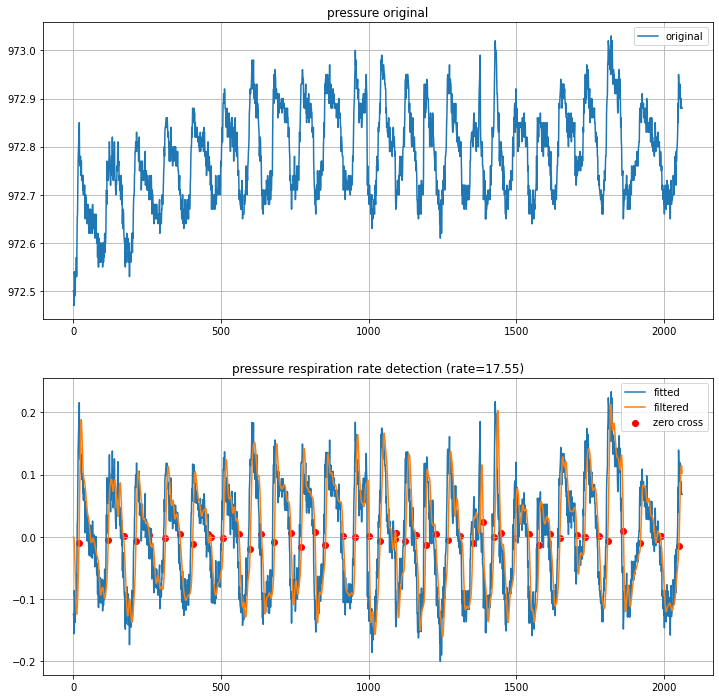

In [27]:
plot_respiration_rate(df_pressure, label='pressure', fit='poly', degree=4)

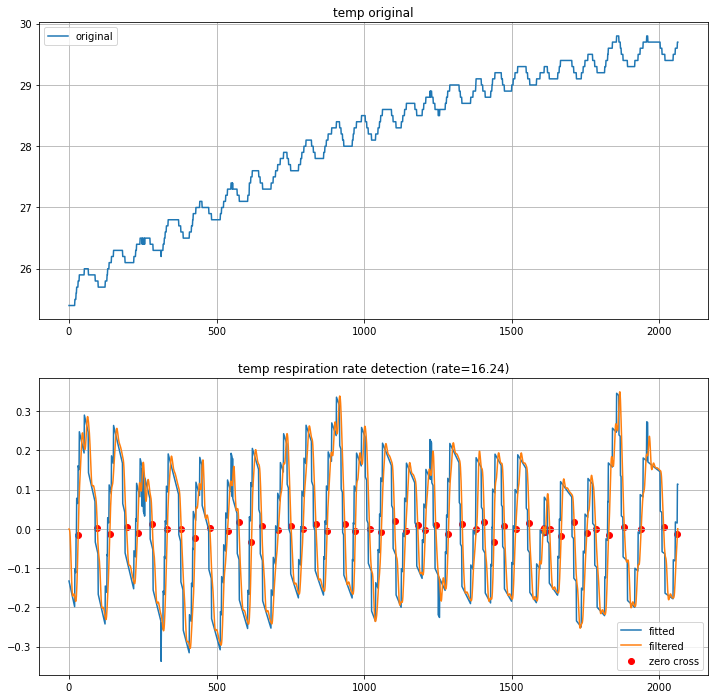

In [29]:
plot_respiration_rate(df_temp, label='temp', fit='poly', degree=3)

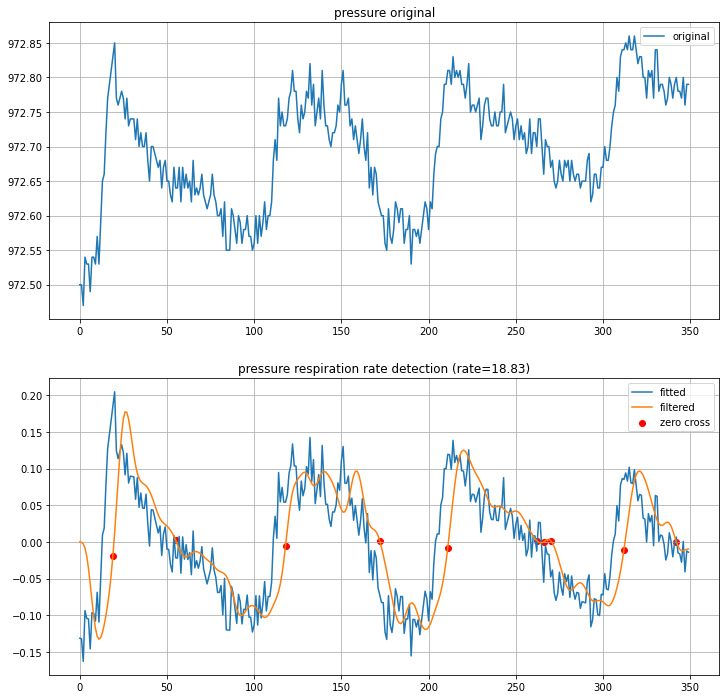

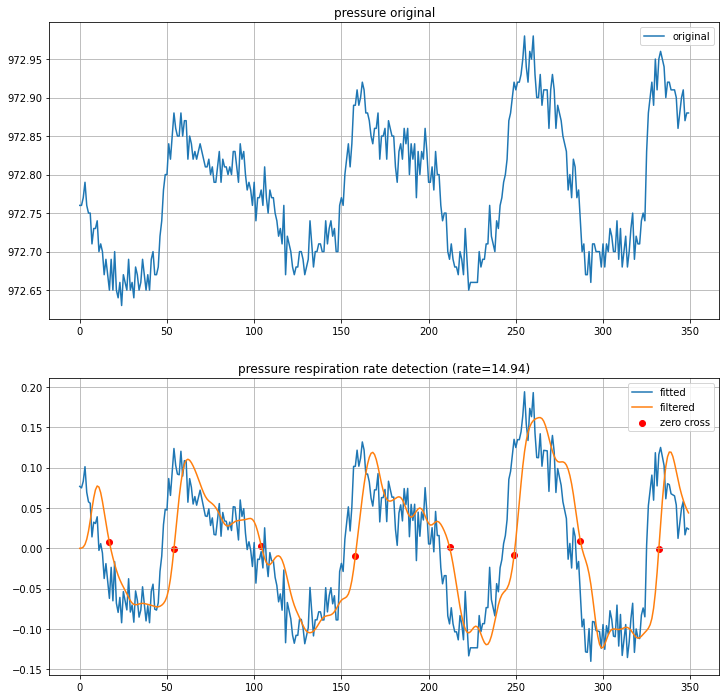

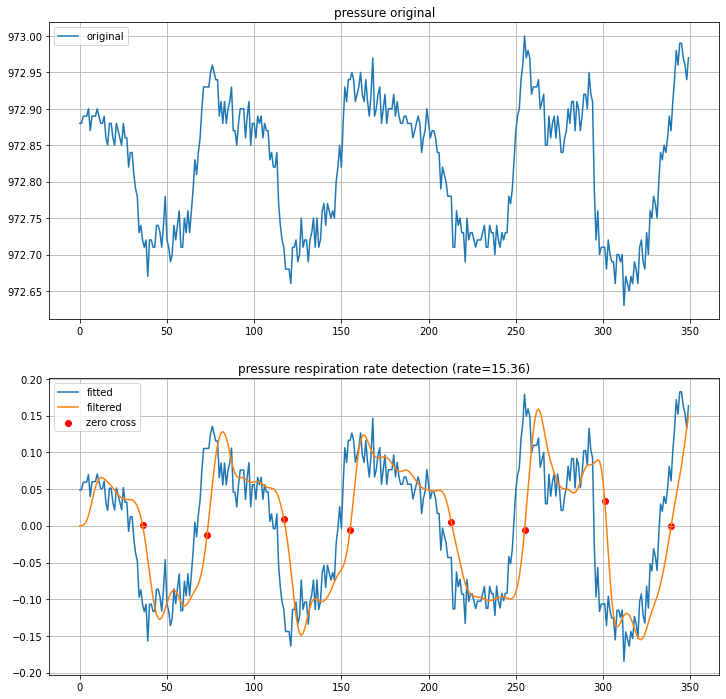

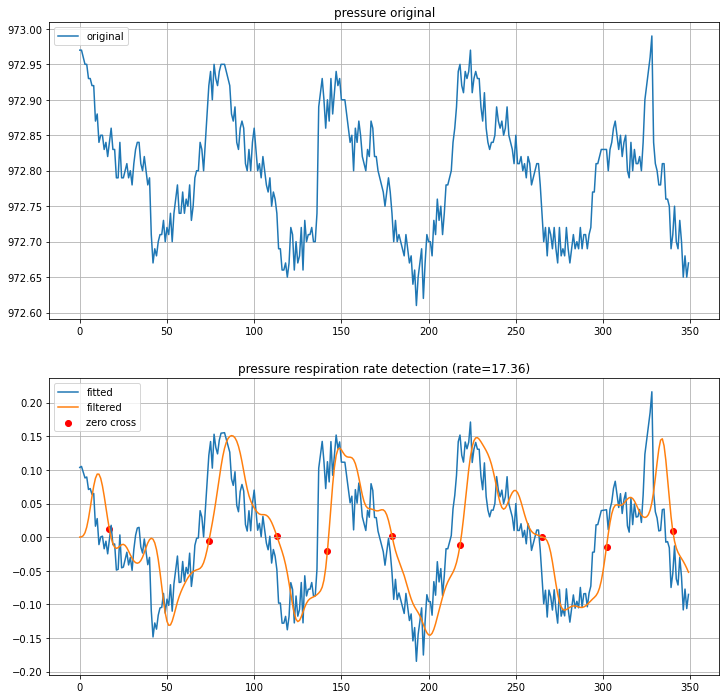

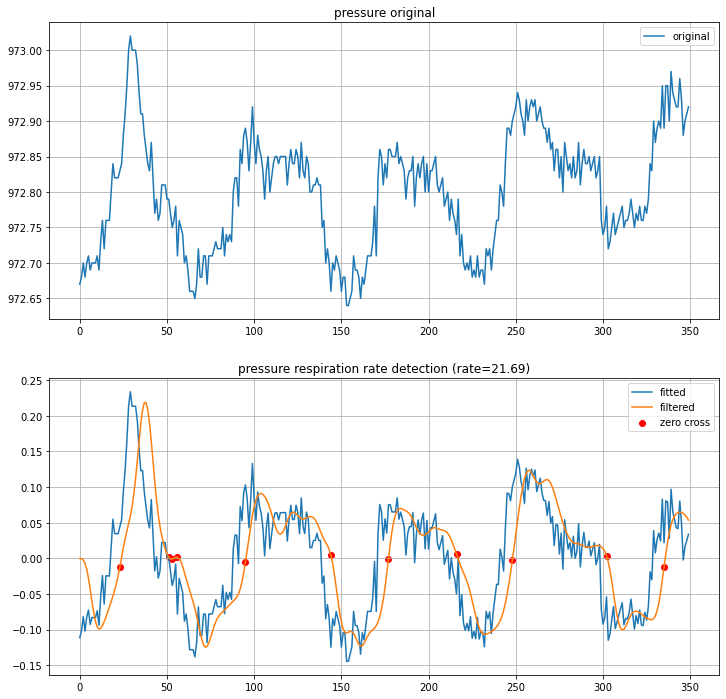

In [32]:
# split up into smaller segments
window = 350

for i in range(0, len(df_pressure)-window, window):
    plot_respiration_rate(df_pressure[i:i+window], label='pressure', fit='poly', degree=4)

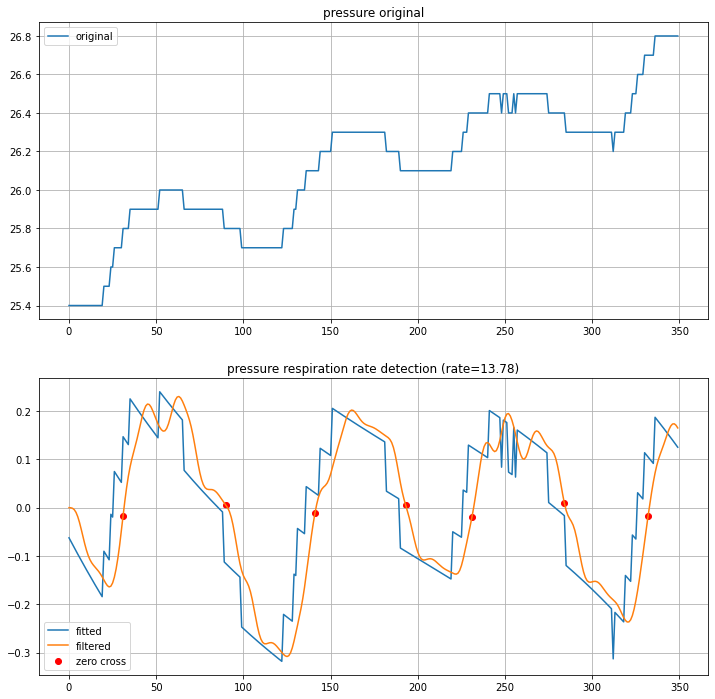

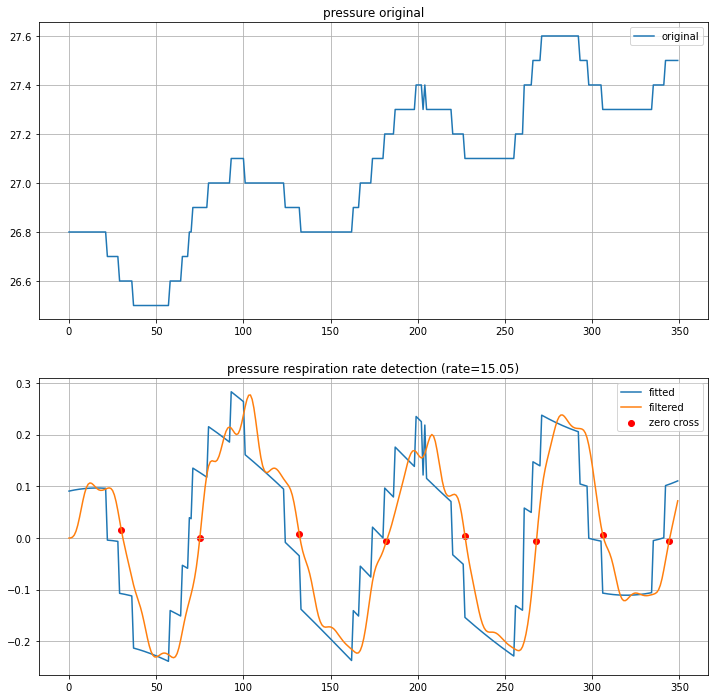

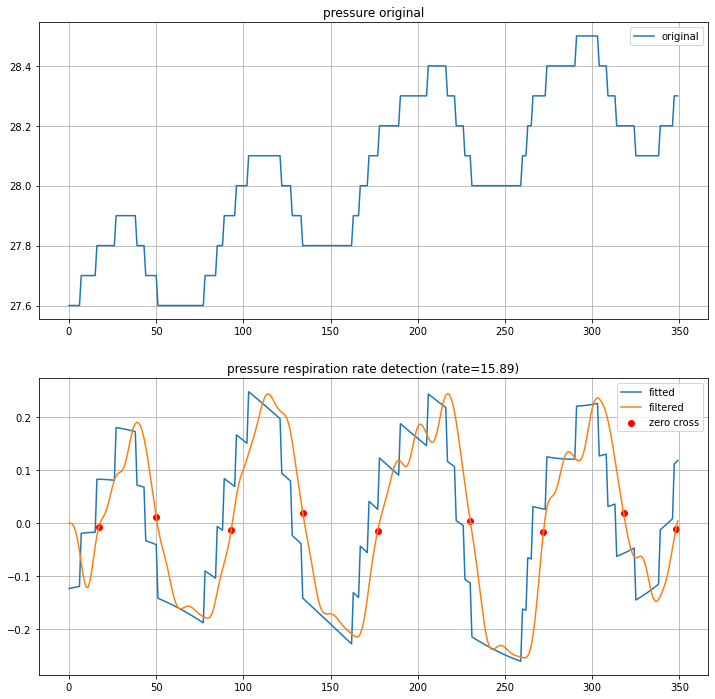

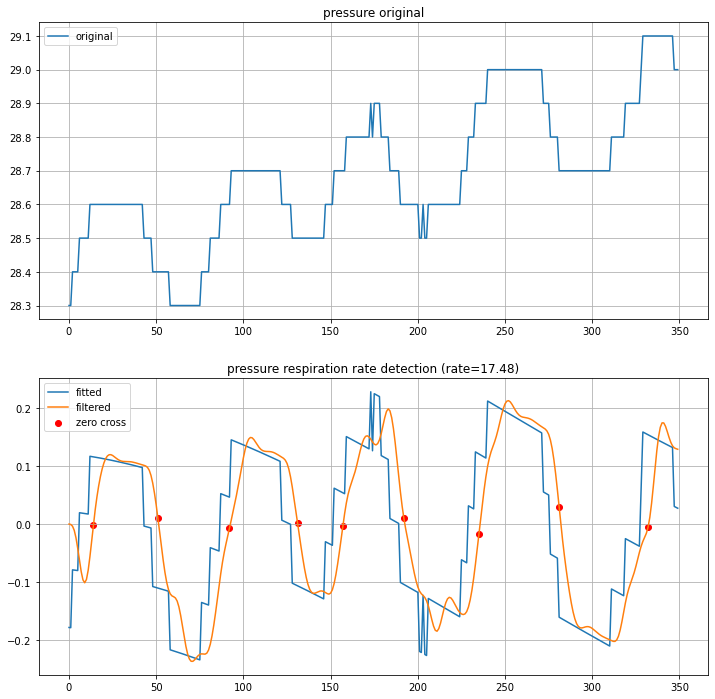

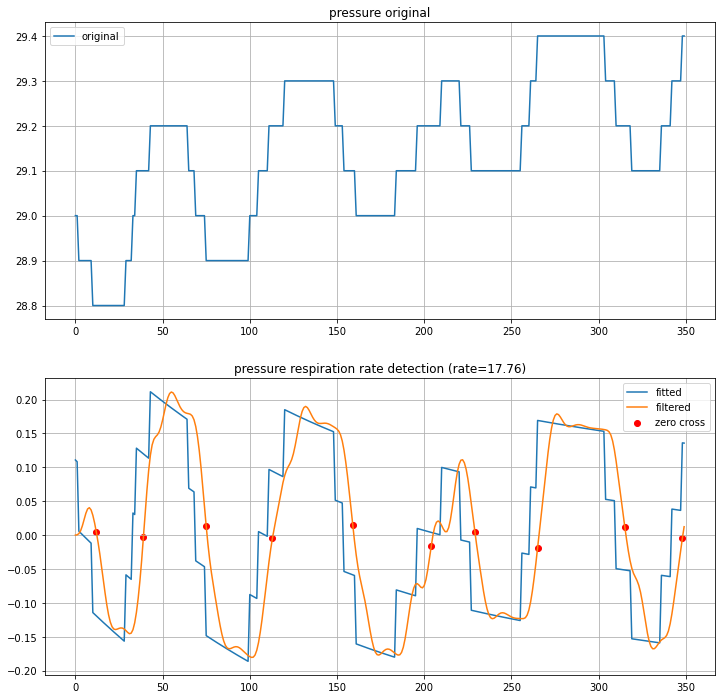

In [33]:
for i in range(0, len(df_temp)-window, window):
    plot_respiration_rate(df_temp[i:i+window], label='pressure', fit='poly', degree=4)